# EDA – Trazas distribuidas (Fase 3)

Este notebook analiza de forma exploratoria las **trazas distribuidas**
generadas por los microservicios simulados e instrumentados con OpenTelemetry.

Objetivos:
- Comprender la estructura de las trazas
- Analizar patrones de latencia y spans
- Identificar señales útiles para RCA
- Definir features basadas en dependencias entre servicios

Las trazas se recolectan mediante:
- OpenTelemetry SDK
- Jaeger (collector + UI)


## Contexto de las trazas

Cada traza representa una petición completa al sistema e incluye múltiples spans que detallan operaciones individuales dentro de esa petición:
- Un `trace_id`
- Uno o más `span_id`
- Servicio origen
- Duración del span
- Relación padre hijo entre spans

Estas relaciones permiten reconstruir:
- Flujos de llamadas
- Dependencias entre servicios
- Causas raíz de degradaciones


In [6]:
!pip install networkx


[notice] A new release of pip is available: 23.0 -> 25.3
[notice] To update, run: C:\Users\kevin_hd2ermy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)


## Dataset de ejemplo de trazas

En esta fase se trabaja con una **exportación simplificada de trazas**
que replica la estructura típica observada en Jaeger.

Este dataset representa:
- Spans individuales
- Servicio al que pertenecen
- Duración
- Relaciones entre spans


In [8]:
traces_df = pd.DataFrame(
    [
        {"trace_id": "t1", "span_id": "s1", "parent": None, "service": "user", "duration_ms": 120},
        {"trace_id": "t1", "span_id": "s2", "parent": "s1", "service": "auth", "duration_ms": 80},
        {"trace_id": "t1", "span_id": "s3", "parent": "s1", "service": "orders", "duration_ms": 200},

        {"trace_id": "t2", "span_id": "s4", "parent": None, "service": "user", "duration_ms": 90},
        {"trace_id": "t2", "span_id": "s5", "parent": "s4", "service": "orders", "duration_ms": 300},

        {"trace_id": "t3", "span_id": "s6", "parent": None, "service": "auth", "duration_ms": 400},
    ]
)

traces_df


,trace_id,span_id,parent,service,duration_ms
0,t1,s1,None,user,120
1,t1,s2,s1,auth,80
2,t1,s3,s1,orders,200
3,t2,s4,None,user,90
4,t2,s5,s4,orders,300
5,t3,s6,None,auth,400


## Distribución de duración de spans


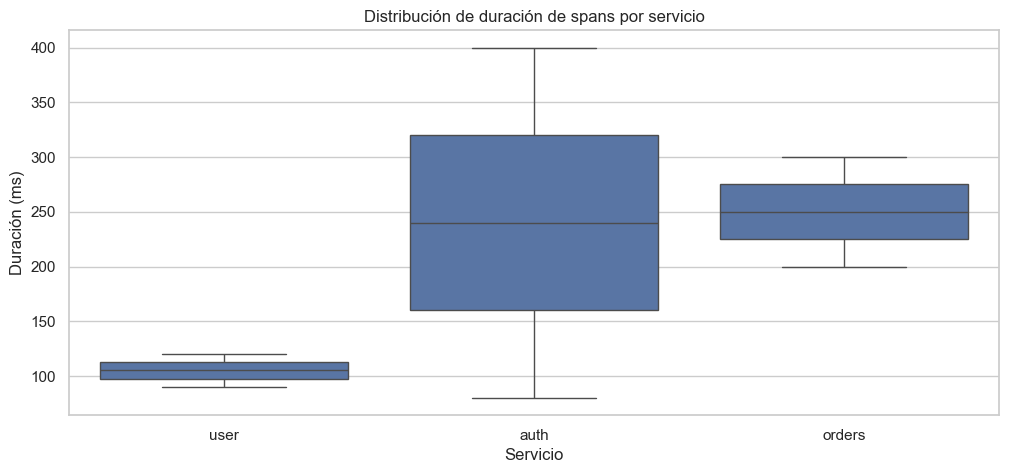

In [10]:
sns.boxplot(
    x="service",
    y="duration_ms",
    data=traces_df
)
plt.title("Distribución de duración de spans por servicio")
plt.ylabel("Duración (ms)")
plt.xlabel("Servicio")
plt.show()


## Número de spans por traza


In [11]:
spans_per_trace = (
    traces_df
    .groupby("trace_id")
    .size()
    .reset_index(name="num_spans")
)

spans_per_trace


,trace_id,num_spans
0,t1,3
1,t2,2
2,t3,1


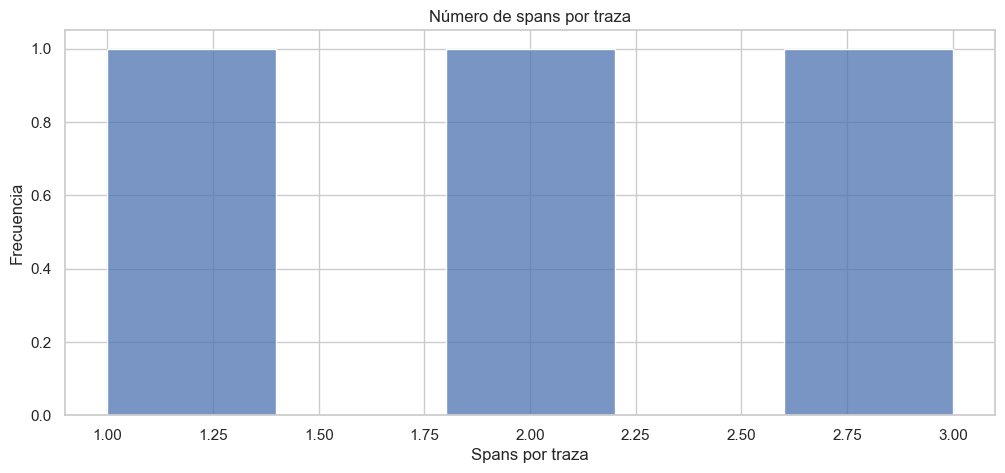

In [12]:
sns.histplot(spans_per_trace["num_spans"], bins=5)
plt.title("Número de spans por traza")
plt.xlabel("Spans por traza")
plt.ylabel("Frecuencia")
plt.show()


## Latencia total por traza


In [13]:
latency_per_trace = (
    traces_df
    .groupby("trace_id")["duration_ms"]
    .sum()
    .reset_index()
)

latency_per_trace


,trace_id,duration_ms
0,t1,400
1,t2,390
2,t3,400


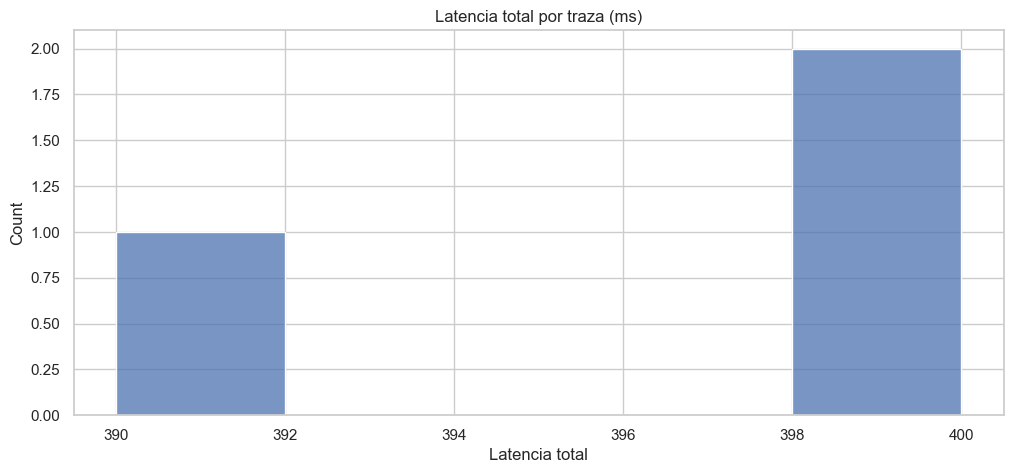

In [14]:
sns.histplot(latency_per_trace["duration_ms"], bins=5)
plt.title("Latencia total por traza (ms)")
plt.xlabel("Latencia total")
plt.show()


## Grafo de dependencias entre servicios

Las relaciones padre–hijo entre spans permiten construir
un **grafo de dependencias** que es fundamental para RCA.


In [15]:
G = nx.DiGraph()

for _, row in traces_df.iterrows():
    if row["parent"] is not None:
        parent_service = traces_df.loc[
            traces_df["span_id"] == row["parent"], "service"
        ].values[0]
        G.add_edge(parent_service, row["service"])


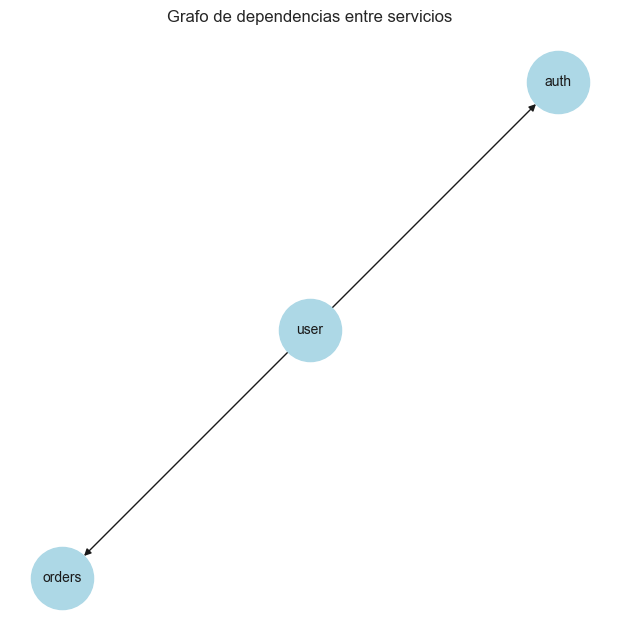

In [16]:
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,
    node_color="lightblue",
    font_size=10,
    arrows=True
)
plt.title("Grafo de dependencias entre servicios")
plt.show()


## Métricas estructurales del grafo

Estas métricas pueden utilizarse como features para RCA:
- In-degree (dependencias entrantes)
- Out-degree (dependencias salientes)


In [17]:
degree_features = pd.DataFrame(
    {
        "service": list(G.nodes),
        "in_degree": [G.in_degree(n) for n in G.nodes],
        "out_degree": [G.out_degree(n) for n in G.nodes],
    }
)

degree_features


,service,in_degree,out_degree
0,user,0,2
1,auth,1,0
2,orders,1,0


## Observaciones clave

- Servicios con mayor out-degree tienden a propagar fallos.
- Spans largos contribuyen significativamente a la latencia total.
- Las trazas permiten correlacionar errores entre servicios.


## Conclusiones del EDA de trazas

El análisis exploratorio de trazas confirma que:

- Las dependencias entre servicios son claramente identificables.
- Las métricas derivadas de spans son útiles para RCA.
- La información de trazas complementa métricas y logs.

En fases posteriores se utilizarán estas observaciones para:
- Ranking de causas raíz
- Correlación de anomalías
- Visualización de incidentes complejos
